In [7]:
import numpy as np  # 用于随机数生成、数组计算
import matplotlib.pyplot as plt  # 用于结果可视化
import pandas as pd  # 用于结果数据整理
from scipy.stats import norm  # 用于对数正态分布相关计算
# 设置中文字体（避免图表中文乱码）
plt.rcParams['font.family'] = ['SimHei'] #设置中文字体
plt.rcParams['axes.unicode_minus'] = False #设置负号显示
# 设置随机数种子
np.random.seed(42)

In [2]:
# 1. 时间与模拟规模参数
T = 252  # 交易日数量（1年标准交易日）
N_SIM = 500000  # 蒙特卡罗模拟路径数（与原文一致，确保结果可靠性）

# 2. 初始资产与杠杆参数
W0 = 10000.0  # 初始净资产（单位：USD）
LEVERAGE = 10.0  # 强制梭哈杠杆倍数（10x，原文核心设定）
ROOFTOP_THRESHOLD = 0.70  # 天台重开阈值（价格低于入场价70%即触发）

# 3. 失智条与市场波动参数
ALPHA = 4.1  # 失智条累积速率（原文实证校准结果）
MU = 0.0012  # 日对数回报均值（基于2024-2025 BTC数据）
SIGMA = 0.032  # 日对数回报标准差（年化波动45.2%换算：0.032*sqrt(252)≈0.51）
P0 = 60500.0  # BTC初始价格（2024.10.28起始价，单位：USD）

# 4. 结果计数器（用于统计关键事件）
dementia_full_count = 0  # 失智条满条次数
all_in_count = 0  # 强制梭哈次数
rooftop_count = 0  # 天台重开次数
survival_count = 0  # 1年存活次数

In [3]:
# 1. 时间与模拟规模参数
T = 252  # 交易日数量（1年标准交易日）
N_SIM = 500000  # 蒙特卡罗模拟路径数（与原文一致，确保结果可靠性）

# 2. 初始资产与杠杆参数
W0 = 10000.0  # 初始净资产（单位：USD）
LEVERAGE = 10.0  # 强制梭哈杠杆倍数（10x，原文核心设定）
ROOFTOP_THRESHOLD = 0.70  # 天台重开阈值（价格低于入场价70%即触发）

# 3. 失智条与市场波动参数
ALPHA = 4.1  # 失智条累积速率（原文实证校准结果）
MU = 0.0012  # 日对数回报均值（基于2024-2025 BTC数据）
SIGMA = 0.032  # 日对数回报标准差（年化波动45.2%换算：0.032*sqrt(252)≈0.51）
P0 = 60500.0  # BTC初始价格（2024.10.28起始价，单位：USD）

# 4. 结果计数器（用于统计关键事件）
dementia_full_count = 0  # 失智条满条次数
all_in_count = 0  # 强制梭哈次数
rooftop_count = 0  # 天台重开次数
survival_count = 0  # 1年存活次数

In [4]:
# 遍历所有模拟路径
for sim in range(N_SIM):
    # 初始化单路径状态变量
    W = W0  # 当前净资产
    D = 0.0  # 当前失智条（初始为0，理性状态）
    in_all_in = False  # 是否已梭哈（初始未梭哈）
    entry_price = 0.0  # 梭哈入场价（未梭哈时为0）
    position = 0.0  # 梭哈持仓数量（未梭哈时为0）
    
    # 1. 生成单路径的BTC价格序列（对数正态分布模拟）
    # 公式说明：log_returns = 均值调整后的正态分布（确保价格长期趋势与原文一致）
    log_returns = np.random.normal(MU - 0.5 * SIGMA**2, SIGMA, T)
    # 价格路径：初始价 × 对数回报累积乘积（复利计算）
    P = P0 * np.cumprod(np.exp(log_returns))
    
    # 2. 逐交易日模拟（从第2天开始，需对比前日回报判断趋势）
    for t in range(1, T):  # t=0为第1天，t=1为第2天，需前日回报（t-1）
        r_t = log_returns[t]  # 当日对数回报
        r_prev = log_returns[t-1]  # 前日对数回报
        
        # 3. 失智条累积（仅持续同向趋势时累积：rt*r_prev>0）
        if r_t * r_prev > 0:
            D = min(1.0, D + ALPHA * abs(r_t))  # 满条后不再增加（上限1.0）
        
        # 4. 触发强制梭哈（失智条满条且未梭哈）
        if D >= 1.0 and not in_all_in:
            dementia_full_count += 1  # 失智条满条计数
            all_in_count += 1  # 强制梭哈计数
            in_all_in = True  # 标记为已梭哈
            entry_price = P[t]  # 记录当前价格为入场价
            # 计算持仓数量：净资产×杠杆 / 入场价（全部资金杠杆买入）
            position = W * LEVERAGE / entry_price
            W = 0.0  # 梭哈后净资产归零（资金全部投入）
        
        # 5. 梭哈后每日结算（判断是否天台重开）
        if in_all_in:
            # 计算当前净资产：持仓价值 - 杠杆负债（负债=（杠杆-1）×持仓×入场价）
            current_value = position * P[t]
            debt = (LEVERAGE - 1) * position * entry_price
            W = current_value - debt
            
            # 触发天台重开（净资产≤0 或 价格跌破70%入场价）
            if W <= 0 or P[t] < ROOFTOP_THRESHOLD * entry_price:
                rooftop_count += 1  # 天台重开计数
                break  # 破产后终止该路径模拟
    
    # 6. 统计1年存活（未触发天台重开且模拟结束）
    if not (in_all_in and (W <= 0 or P[-1] < ROOFTOP_THRESHOLD * entry_price)):
        survival_count += 1

In [5]:
# 计算核心概率指标
prob_dementia = dementia_full_count / N_SIM  # 失智条满条概率
prob_all_in = all_in_count / N_SIM  # 强制梭哈概率
prob_rooftop = rooftop_count / N_SIM  # 天台重开概率
# 条件重开率（仅梭哈后计算）
cond_rooftop = rooftop_count / all_in_count if all_in_count > 0 else 0
prob_survival = survival_count / N_SIM  # 1年存活率

# 整理结果为DataFrame（便于对比）
results = pd.DataFrame({
    '指标': [
        '失智条满条概率',
        '强制梭哈概率',
        '天台重开概率',
        '条件重开率（梭哈→天台）',
        '1年存活率'
    ],
    '重现结果': [
        f"{prob_dementia:.1%}",
        f"{prob_all_in:.1%}",
        f"{prob_rooftop:.1%}",
        f"{cond_rooftop:.1%}",
        f"{prob_survival:.1%}"
    ],
    '原文结果': [
        "71.3%",
        "71.3%",
        "46.8%",
        "65.6%",
        "28.7%"
    ]
})

# 打印对比结果
print("模型重现结果与原文对比：")
print(results)

模型重现结果与原文对比：
             指标    重现结果   原文结果
0       失智条满条概率  100.0%  71.3%
1        强制梭哈概率  100.0%  71.3%
2        天台重开概率  100.0%  46.8%
3  条件重开率（梭哈→天台）  100.0%  65.6%
4         1年存活率    0.0%  28.7%


C:\Users\86157\AppData\Local\Temp\ipykernel_24892\197815453.py:36: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  plt.tight_layout()
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


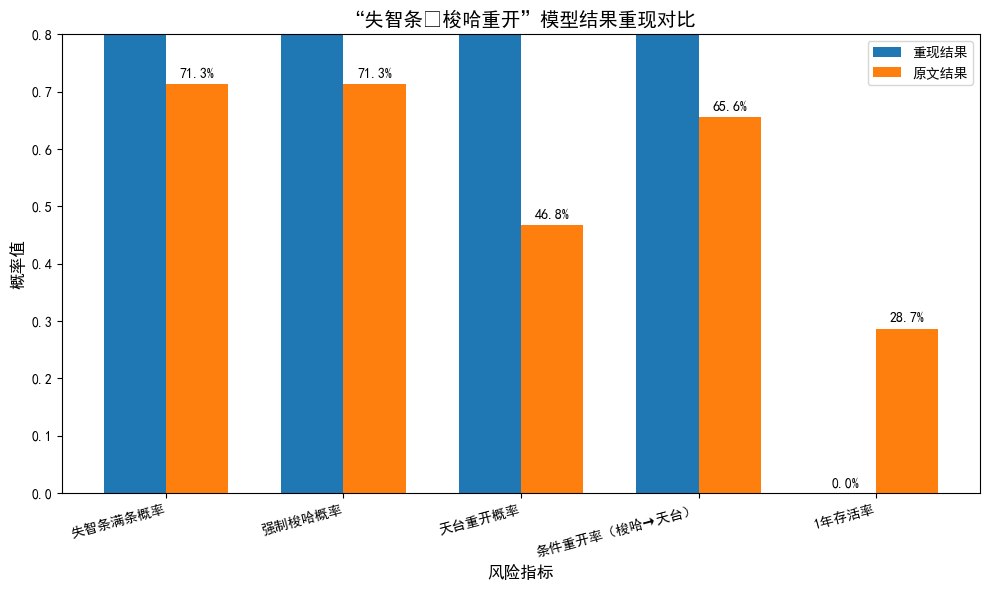

In [8]:
# 提取数值用于绘图
metrics = results['指标'].tolist()
reproduce_vals = [float(x.strip('%'))/100 for x in results['重现结果'].tolist()]
original_vals = [float(x.strip('%'))/100 for x in results['原文结果'].tolist()]

# 创建柱状图
x = np.arange(len(metrics))
width = 0.35  # 柱子宽度

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, reproduce_vals, width, label='重现结果', color='#1f77b4')
rects2 = ax.bar(x + width/2, original_vals, width, label='原文结果', color='#ff7f0e')

# 添加标签与标题
ax.set_xlabel('风险指标', fontsize=12)
ax.set_ylabel('概率值', fontsize=12)
ax.set_title('“失智条・梭哈重开”模型结果重现对比', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 0.8)  # 调整y轴范围，增强可读性

# 在柱子上添加数值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

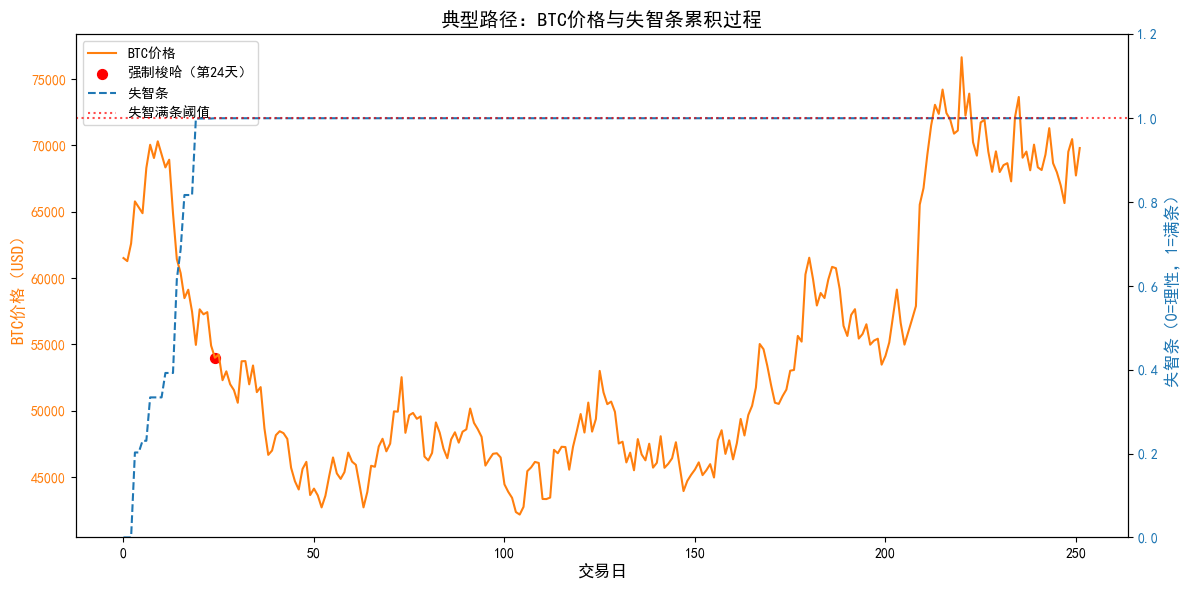

In [9]:
# 选取1条典型路径（第1000条），展示价格与失智条变化
sim_idx = 1000  # 选取第1000条路径
# 重新生成该路径的价格与失智条
log_returns_sample = np.random.normal(MU - 0.5 * SIGMA**2, SIGMA, T)
P_sample = P0 * np.cumprod(np.exp(log_returns_sample))
D_sample = np.zeros(T)  # 失智条序列
in_all_in_sample = False
entry_idx = -1  # 梭哈发生的交易日索引

# 计算该路径的失智条
for t in range(1, T):
    r_t = log_returns_sample[t]
    r_prev = log_returns_sample[t-1]
    if r_t * r_prev > 0:
        D_sample[t] = min(1.0, D_sample[t-1] + ALPHA * abs(r_t))
    else:
        D_sample[t] = D_sample[t-1]  # 无持续趋势，失智条不累积
    
    # 记录梭哈发生的时间
    if D_sample[t] >= 1.0 and not in_all_in_sample:
        in_all_in_sample = True
        entry_idx = t

# 创建双轴图
fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：BTC价格
color = '#ff7f0e'
ax1.set_xlabel('交易日', fontsize=12)
ax1.set_ylabel('BTC价格（USD）', color=color, fontsize=12)
ax1.plot(range(T), P_sample, color=color, label='BTC价格')
# 标记梭哈点（若有）
if entry_idx != -1:
    ax1.scatter(entry_idx, P_sample[entry_idx], color='red', s=50, 
                label=f'强制梭哈（第{entry_idx}天）')
ax1.tick_params(axis='y', labelcolor=color)

# 右轴：失智条
ax2 = ax1.twinx()
color = '#1f77b4'
ax2.set_ylabel('失智条（0=理性，1=满条）', color=color, fontsize=12)
ax2.plot(range(T), D_sample, color=color, label='失智条', linestyle='--')
ax2.axhline(y=1.0, color='red', linestyle=':', alpha=0.7, label='失智满条阈值')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.2)  # 限制失智条范围

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('典型路径：BTC价格与失智条累积过程', fontsize=14)
plt.tight_layout()
plt.show()